## Seinfeld - EDA transcripts
**Program:** 01_sfeld_eda.ipynb <br>
**Created by:** Chris Chan<br>
**Date:** Feb 16, 2021<br>
**Purpose:** bring in data, count vectorize, etc. <br>
**Key Features:** 

**Key sites:**<br>
https://letstalkdata.com/2013/06/web-scraping-and-corpus-analysis-with-python-a-seinfeld-case-study/


In [23]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import NMF

In [24]:
import glob
import os
from collections import defaultdict
import re
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

In [25]:
import nltk
import os
import spacy
import re
import string
import pickle
from itertools import cycle
import matplotlib.pyplot as plt
from nltk import stem
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
from nltk.tokenize import word_tokenize, sent_tokenize, MWETokenizer
from gensim import corpora, models, similarities, matutils
from sklearn.decomposition import TruncatedSVD, NMF
from corextopic import corextopic, vis_topic
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import plotly.graph_objects as go

In [26]:
# def processFile(filename):
#     f = open(filename, 'r')
#     content = f.read()
#     content = re.sub('[^A-z \n]','',content)
#     return content.split()

**We read through all the docments and build a list-of-list of words:**

In [38]:
df = pd.read_csv('/Users/chrischan/Documents/02_Class/Metis/bootcamp/githubrepo/Metis_proj4/data/seinfeld_scripts_clean2.csv')

In [39]:
df.head()

,character,text,episodeno,seid,season
0,JERRY,Do you know what this is all about? Do you kno...,1,S01E01,1
1,JERRY,"(pointing at Georges shirt) See, to me, that b...",1,S01E01,1
2,GEORGE,Are you through?,1,S01E01,1
3,JERRY,"You do of course try on, when you buy?",1,S01E01,1
4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",1,S01E01,1


In [40]:
for text in df["text"][0:10]:
    print(text)

Do you know what this is all about? Do you know, why were here? To be out, this is out and out is one of the single most enjoyable experiences of life. People did you ever hear people talking about We should go out? This is what theyre talking about this whole thing, were all out now, no one is home. Not one person here is home, were all out! There are people tryin to find us, they dont know where we are. (on an imaginary phone) Did you ring?, I cant find him. Where did he go? He didnt tell me where he was going. He must have gone out. You wanna go out you get ready, you pick out the clothes, right? You take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation Then youre standing around, whatta you do? You go We gotta be getting back. Once youre out, you wanna get back! You wanna go to sleep, you wanna get up, you wanna go out again tomorrow, right? Where ever you are in life, its my feeling, youve gotta go.
(pointing at Georges shirt) See, 

## Data Cleaning

In [41]:
breaks = lambda x: re.sub("\n", " ", x)
alphanumeric = lambda x: re.sub("\w*\d\w*", "", x)
punc_lower = lambda x: re.sub("[%s]" % re.escape(string.punctuation), "", x.lower())

In [42]:
df["textmod"] = df["text"].map(breaks).map(alphanumeric).map(punc_lower)
df["character"] = df["character"].str.lower()

In [43]:
df

,character,text,episodeno,seid,season,textmod
0,jerry,Do you know what this is all about? Do you kno...,1,S01E01,1,do you know what this is all about do you know...
1,jerry,"(pointing at Georges shirt) See, to me, that b...",1,S01E01,1,pointing at georges shirt see to me that butto...
2,george,Are you through?,1,S01E01,1,are you through
3,jerry,"You do of course try on, when you buy?",1,S01E01,1,you do of course try on when you buy
4,george,"Yes, it was purple, I liked it, I dont actuall...",1,S01E01,1,yes it was purple i liked it i dont actually r...
...,...,...,...,...,...,...
54593,jerry,Grand theft auto - don't steal any of my jokes.,23,S09E23,9,grand theft auto dont steal any of my jokes
54594,prisoner 3,You suck - I'm gonna cut you.,23,S09E23,9,you suck im gonna cut you
54595,jerry,"Hey, I don't come down to where you work, and ...",23,S09E23,9,hey i dont come down to where you work and kno...
54596,guard,"Alright, Seinfeld, that's it. Let's go. Come on.",23,S09E23,9,alright seinfeld thats it lets go come on


**Attach char to each line if/when summarizing to episode**

In [44]:
df["episodetext"] = df['character']+": "+df["textmod"] 
df.head()

,character,text,episodeno,seid,season,textmod,episodetext
0,jerry,Do you know what this is all about? Do you kno...,1,S01E01,1,do you know what this is all about do you know...,jerry: do you know what this is all about do y...
1,jerry,"(pointing at Georges shirt) See, to me, that b...",1,S01E01,1,pointing at georges shirt see to me that butto...,jerry: pointing at georges shirt see to me tha...
2,george,Are you through?,1,S01E01,1,are you through,george: are you through
3,jerry,"You do of course try on, when you buy?",1,S01E01,1,you do of course try on when you buy,jerry: you do of course try on when you buy
4,george,"Yes, it was purple, I liked it, I dont actuall...",1,S01E01,1,yes it was purple i liked it i dont actually r...,george: yes it was purple i liked it i dont ac...


In [45]:
def tprint(data,var,nobs):
    for text in data[var][0:nobs]:
        print(text)

In [46]:
tprint(df,"episodetext",10)
# for text in df["episodetext"][0:10]:
#     print(text)

jerry: do you know what this is all about do you know why were here to be out this is out and out is one of the single most enjoyable experiences of life people did you ever hear people talking about we should go out this is what theyre talking about this whole thing were all out now no one is home not one person here is home were all out there are people tryin to find us they dont know where we are on an imaginary phone did you ring i cant find him where did he go he didnt tell me where he was going he must have gone out you wanna go out you get ready you pick out the clothes right you take the shower you get all ready get the cash get your friends the car the spot the reservation then youre standing around whatta you do you go we gotta be getting back once youre out you wanna get back you wanna go to sleep you wanna get up you wanna go out again tomorrow right where ever you are in life its my feeling youve gotta go
jerry: pointing at georges shirt see to me that button is in the wor

## Costanza only

In [48]:
df = df.loc[df["character"]=='george']

In [49]:
df

,character,text,episodeno,seid,season,textmod,episodetext
2,george,Are you through?,1,S01E01,1,are you through,george: are you through
4,george,"Yes, it was purple, I liked it, I dont actuall...",1,S01E01,1,yes it was purple i liked it i dont actually r...,george: yes it was purple i liked it i dont ac...
6,george,"(on an imaginary microphone) Uh, no, not at th...",1,S01E01,1,on an imaginary microphone uh no not at this time,george: on an imaginary microphone uh no not a...
9,george,"Are, are you sure this is decaf? Wheres the or...",1,S01E01,1,are are you sure this is decaf wheres the oran...,george: are are you sure this is decaf wheres ...
13,george,How come youre not doin the second show tomorrow?,1,S01E01,1,how come youre not doin the second show tomorrow,george: how come youre not doin the second sho...
...,...,...,...,...,...,...,...
54518,george,What?,23,S09E23,9,what,george: what
54565,george,You had to hop! You had to hop on the plane.,23,S09E23,9,you had to hop you had to hop on the plane,george: you had to hop you had to hop on the p...
54581,george,Really?,23,S09E23,9,really,george: really
54583,george,Haven't we had this conversation before?,23,S09E23,9,havent we had this conversation before,george: havent we had this conversation before


Since we want to look at episode level we can include names as stopwords

In [50]:
from sklearn.feature_extraction import text 
#chars = ['seinfeld','jerry','elaine','george','kramer','newman','morty','helen','frank','peterman','puddy','steinbrenner']
my_stop_words = nltk.corpus.stopwords.words('english')
# my_stop_words.extend(chars) #text.ENGLISH_STOP_WORDS.union(chars)
# my_stop_words.extend(ch_list4)

In [51]:
my_stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [52]:
df.head()
#tprint(df,"textmod2",10)

,character,text,episodeno,seid,season,textmod,episodetext
2,george,Are you through?,1,S01E01,1,are you through,george: are you through
4,george,"Yes, it was purple, I liked it, I dont actuall...",1,S01E01,1,yes it was purple i liked it i dont actually r...,george: yes it was purple i liked it i dont ac...
6,george,"(on an imaginary microphone) Uh, no, not at th...",1,S01E01,1,on an imaginary microphone uh no not at this time,george: on an imaginary microphone uh no not a...
9,george,"Are, are you sure this is decaf? Wheres the or...",1,S01E01,1,are are you sure this is decaf wheres the oran...,george: are are you sure this is decaf wheres ...
13,george,How come youre not doin the second show tomorrow?,1,S01E01,1,how come youre not doin the second show tomorrow,george: how come youre not doin the second sho...


## Lemmatize

In [53]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
spacy_lemmatize = lambda x: " ".join([token.lemma_ for token in nlp(x)])

In [54]:
df["lemmatized"] = df["textmod"].apply(spacy_lemmatize)
df

<ipython-input-54-fd8cc5396c51>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["lemmatized"] = df["textmod"].apply(spacy_lemmatize)


,character,text,episodeno,seid,season,textmod,episodetext,lemmatized
2,george,Are you through?,1,S01E01,1,are you through,george: are you through,be you through
4,george,"Yes, it was purple, I liked it, I dont actuall...",1,S01E01,1,yes it was purple i liked it i dont actually r...,george: yes it was purple i liked it i dont ac...,yes it be purple I like it I do nt actually re...
6,george,"(on an imaginary microphone) Uh, no, not at th...",1,S01E01,1,on an imaginary microphone uh no not at this time,george: on an imaginary microphone uh no not a...,on an imaginary microphone uh no not at this time
9,george,"Are, are you sure this is decaf? Wheres the or...",1,S01E01,1,are are you sure this is decaf wheres the oran...,george: are are you sure this is decaf wheres ...,be be you sure this be decaf where s the orang...
13,george,How come youre not doin the second show tomorrow?,1,S01E01,1,how come youre not doin the second show tomorrow,george: how come youre not doin the second sho...,how come you re not doin the second show tomorrow
...,...,...,...,...,...,...,...,...
54518,george,What?,23,S09E23,9,what,george: what,what
54565,george,You had to hop! You had to hop on the plane.,23,S09E23,9,you had to hop you had to hop on the plane,george: you had to hop you had to hop on the p...,you have to hop you have to hop on the plane
54581,george,Really?,23,S09E23,9,really,george: really,really
54583,george,Haven't we had this conversation before?,23,S09E23,9,havent we had this conversation before,george: havent we had this conversation before,have nt we have this conversation before


### Doc: Episode Level

Create 2 separate ds: 1 with speaker and 1 without speaker

1. with speaker

In [55]:
df_sp = df.copy()

## Doc: Episode Level
df_sp = df_sp.drop(['character','text','textmod','episodeno','lemmatized','season'],axis=1)
# concatenate the string 
df_sp['episodetext'] = df_sp.groupby(['seid'])['episodetext'].transform(lambda x : ' '.join(x)) 

# drop duplicate data 
df_sp = df_sp.drop_duplicates()
  
# show the dataframe 
print(df_sp) 

         seid                                        episodetext
2      S01E01  george: are you through george: yes it was pur...
567    S01E02  george: from the intercom yeah george: to jerr...
838    S01E03  george: i had to say something chuckles i had ...
1080   S01E04  george: i never heard him say anything really ...
1309   S02E01  george: she cant kill me right george: people ...
...       ...                                                ...
52607  S09E17  george: i read somewhere that this brentanos i...
52948  S09E18  george: marios pizza george: just as she was h...
53206  S09E19  george: what happened to your voice george: we...
53569  S09E20  george: man im starving george: because ballpa...
53885  S09E23  george: i cant eat this without catsup would i...

[172 rows x 2 columns]


2. without speaker and removing pronouns 

In [56]:
df_nosp = df.copy()

## Doc: Episode Level
df_nosp = df_nosp.drop(['character','text','textmod','episodetext','episodeno','season'],axis=1)
# concatenate the string 
df_nosp['lemmatized'] = df_nosp.groupby(['seid'])['lemmatized'].transform(lambda x : ' '.join(x)) 

# drop duplicate data 
df_nosp = df_nosp.drop_duplicates()
  
# show the dataframe 
print(df_nosp) 

         seid                                         lemmatized
2      S01E01  be you through yes it be purple I like it I do...
567    S01E02  from the intercom yeah to jerry ready hey elai...
838    S01E03  I have to say something chuckle I have to say ...
1080   S01E04  I never hear he say anything really funny you ...
1309   S02E01  she ca nt kill I right people break up all the...
...       ...                                                ...
52607  S09E17  I read somewhere that this brentanos be the pl...
52948  S09E18  mario pizza just as she be hey mario remember ...
53206  S09E19  what happen to your voice well jerry I be thin...
53569  S09E20  man I m starve because ballpark food do nt cou...
53885  S09E23  I ca nt eat this without catsup would it kill ...

[172 rows x 2 columns]


Use the above for topic modeling (df_nosp)

## Manual: Count Vectorizer (term doc matrix)

In [57]:
# input params 

vectorizer = CountVectorizer(stop_words = my_stop_words) #'english')
doc_word = vectorizer.fit_transform(df_nosp.lemmatized)
doc_word.shape

(172, 6266)

In [58]:
pd.DataFrame(doc_word.toarray(),columns=vectorizer.get_feature_names())

,aaaa,aaaaaah,aaahh,aaarrrrrgh,aah,aahhhh,aahhnono,aahhrgh,aand,aanyway,...,zero,zinger,zionist,zip,zipper,zippo,zippy,zone,zoo,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
168,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
169,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
170,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [219]:
import csv
with open('stoplist.csv','w') as f:
    write=csv.writer(f)
    write.writerow(my_stop_words)

## Topic Modeling

**Let's start with NMF**

Convert Doc Word to Doc Topic

In [59]:
# define the number of topics you want to reduce to
k=10
nmf_model = NMF(k)

# read lecture on how nmf is working
doc_topic = nmf_model.fit_transform(doc_word)
doc_topic.shape

(172, 10)

Now we have 173 episodes and 15 topics 

Convert Doc topic to Topic Word

In [60]:
# basically you have a transposed DF of k topics and n words in your corpus
topic_word = nmf_model.components_
topic_word.shape

(10, 6266)

In [61]:
topic_word

array([[0.0093233 , 0.        , 0.01029436, ..., 0.01292783, 0.        ,
        0.00765151],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00960846,
        0.02383483],
       ...,
       [0.03030784, 0.        , 0.        , ..., 0.01140533, 0.00362134,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00948008,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.0034126 ,
        0.        ]])

We started with ~17k words and now we have 11k which is better

Let's look at the words per document with the highest weights (top k words)

In [62]:
topw=10

# obtain actual topic words that resulted in teh NMF model
words = vectorizer.get_feature_names()
t = nmf_model.components_.argsort(axis=1)[:,-1:-topw:-1]
topic_words = [[words[e] for e in l] for l in t]
topic_words

[['nt', 'know', 'ca', 'na', 'gon', 'look', 'see', 'good', 'tell'],
 ['nt', 'call', 'like', 'oh', 'right', 'coffee', 'ca', 'say', 'go'],
 ['get', 'nt', 'go', 'car', 'guy', 'like', 'back', 'ta', 'look'],
 ['jerry', 'nt', 'funny', 'elaine', 'look', 'nina', 'oh', 'good', 'uh'],
 ['go', 'nt', 'know', 'say', 'hey', 'well', 'could', 'oh', 'tell'],
 ['uh', 'know', 'yeah', 'elaine', 'oh', 'marisa', 'tomei', 'yes', 'susan'],
 ['right', 'know', 'yeah', 'get', 'good', 'come', 'go', 'show', 'gon'],
 ['twix', 'hey', 'bar', 'candy', 'right', 'get', 'nt', 'ho', 'mechanic'],
 ['like', 'nt', 'think', 'get', 'know', 'say', 'go', 'one', 'could'],
 ['well', 'yeah', 'oh', 'see', 'yes', 'right', 'really', 'tell', 'say']]

## Automate Topic Modeling

**Trying to udnerstand components of each vectorizer first**

In [63]:
# Fit transform doc word to doc topic        
# vec is your count vectorizer. these are bag of words
#sein.feature_names = vec.get_feature_names()
# putting all feature names into an array
words_array = list(np.asarray(vectorizer.get_feature_names()))

In [64]:
mat_corpus = matutils.Sparse2Corpus(doc_word.transpose())

Looks like sparse2corpus takes our doc word (sparse matrix) and for every document (173 eps) it provides a tuple of (unique word id, count of words). So you will have different unique words per document.

In [65]:
mat_corpus[0]

[(53, 1),
 (56, 1),
 (85, 1),
 (158, 1),
 (159, 1),
 (166, 2),
 (174, 1),
 (182, 1),
 (187, 1),
 (206, 1),
 (207, 1),
 (221, 1),
 (225, 1),
 (261, 4),
 (263, 1),
 (275, 1),
 (283, 2),
 (296, 5),
 (354, 1),
 (359, 1),
 (372, 1),
 (379, 1),
 (382, 2),
 (384, 1),
 (430, 2),
 (447, 1),
 (453, 1),
 (472, 2),
 (493, 2),
 (495, 1),
 (518, 1),
 (552, 1),
 (556, 1),
 (636, 1),
 (648, 1),
 (668, 1),
 (669, 1),
 (685, 1),
 (702, 2),
 (720, 1),
 (723, 1),
 (729, 1),
 (739, 4),
 (748, 1),
 (754, 7),
 (801, 1),
 (821, 4),
 (922, 1),
 (934, 2),
 (938, 3),
 (955, 1),
 (1032, 8),
 (1043, 2),
 (1094, 1),
 (1118, 1),
 (1139, 1),
 (1164, 1),
 (1183, 2),
 (1192, 1),
 (1212, 1),
 (1338, 1),
 (1343, 2),
 (1365, 1),
 (1394, 1),
 (1426, 1),
 (1471, 1),
 (1479, 1),
 (1525, 2),
 (1530, 2),
 (1546, 1),
 (1557, 1),
 (1595, 1),
 (1603, 1),
 (1670, 1),
 (1683, 1),
 (1774, 3),
 (1777, 2),
 (1789, 1),
 (1825, 1),
 (1833, 1),
 (1844, 2),
 (1849, 1),
 (1874, 1),
 (1914, 3),
 (1920, 1),
 (1951, 1),
 (1958, 2),
 (1980, 1)

In [66]:
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())

Here we just create a dictionary of word id and the actual word itself

In [67]:
id2word

{6217: 'yes',
 4357: 'purple',
 3144: 'like',
 3729: 'nt',
 56: 'actually',
 4445: 'recall',
 1118: 'consider',
 729: 'button',
 2671: 'imaginary',
 3430: 'microphone',
 5758: 'uh',
 5578: 'time',
 5356: 'sure',
 1338: 'decaf',
 3838: 'orange',
 2731: 'indicator',
 1032: 'come',
 1530: 'doin',
 4784: 'second',
 4922: 'show',
 5607: 'tomorrow',
 5956: 'wait',
 6131: 'woman',
 2337: 'ha',
 5422: 'take',
 3443: 'milk',
 2873: 'jerry',
 4364: 'put',
 5418: 'table',
 5045: 'smile',
 2995: 'know',
 2385: 'happen',
 3785: 'oh',
 3721: 'nothing',
 2281: 'great',
 754: 'call',
 4728: 'say',
 5975: 'want',
 2229: 'go',
 3674: 'night',
 2231: 'god',
 552: 'bless',
 1426: 'devil',
 6068: 'whistle',
 1471: 'disapprovingly',
 2519: 'ho',
 3353: 'maybe',
 6022: 'well',
 2186: 'get',
 5594: 'together',
 2410: 'hate',
 5469: 'tell',
 2240: 'gon',
 3597: 'na',
 4794: 'see',
 4183: 'polite',
 4597: 'right',
 5974: 'wanna',
 379: 'backup',
 4785: 'secondline',
 2940: 'justincase',
 636: 'bplan',
 1139: 'c

**lets export to see what we have**

In [72]:
import csv
def xportwords(id2word):
    with open('idworddict.csv', 'w') as f:
        for key in id2word.keys():
            f.write("%s,%s\n"%(key,id2word[key]))

def xportwfreq(corpus):
    with open('wordfreq.csv','w') as out:
        csv_out=csv.writer(out)
        csv_out.writerow(['name','num'])
        for row in corpus:
            csv_out.writerow(row)

**Define Pipeline**

Let's try defining a pipeline for LMF and word checking

In [68]:
class topic_model():

    def __init__(sein, data, vectorizer, model, num_topics  ):
        sein.data = data
        sein.vectorizer = vectorizer
        sein.model = model
        sein.num_topics = num_topics 
        

    # count vectorize
    def vectorize(sein):
        if sein.vectorizer == "cv":
            if sein.model == "corex":
                vec = CountVectorizer(stop_words=my_stop_words,  max_df=maxdf, min_df=mindf, binary=True) 
            else:
                vec = CountVectorizer(stop_words=my_stop_words,  max_df=maxdf ) #,min_df=mindf ngram_range=(1, 3)) 
        elif sein.vectorizer == "tfidf":
            vec = TfidfVectorizer(stop_words=my_stop_words,  max_df=maxdf, min_df=mindf ) #ngram_range=(1, 3),
        else: print("Please define a valid vectorizer.")

        # Fit transform doc word to doc topic        
        sein.doc_word = vec.fit_transform(sein.data)
        # vec is your count vectorizer. these are bag of words
        sein.feature_names = vec.get_feature_names()
        # putting all feature names into an array
        sein.words = list(np.asarray(vec.get_feature_names()))
        # transform sparse mat to dict
        sein.corpus = matutils.Sparse2Corpus(sein.doc_word.transpose())
        sein.id2word = dict((v, k) for k, v in vec.vocabulary_.items())
        
        
        xportwfreq(sein.corpus)
        xportwords(sein.id2word)

    def display_topics(sein):
        if sein.model == "lda":
            model = models.LdaModel(corpus=sein.corpus, num_topics=sein.num_topics, id2word=sein.id2word, passes=5, random_state=42)
            topics = model.print_topics()
            print(topics)
            
        elif sein.model == "corex":
            model = corextopic.Corex(n_hidden=sein.num_topics, words=sein.words, seed=1, max_iter=500)
            model.fit(sein.doc_word, words=sein.words, docs=sein.data)
            topics = model.get_topics()
            print(topics)
            for n,topic in enumerate(topics):
                topic_words,_ = zip(*topic)
            print('{}: '.format(n) + ','.join(topic_words))

        else:
            if sein.model == "lsa":
                model = TruncatedSVD(sein.num_topics)
            elif sein.model == "nmf":
                model = NMF(sein.num_topics)
            else: print("Please define a valid model.")

            doc_topic = model.fit_transform(sein.doc_word)
            
            # components are # of labels
            for ix, topic in enumerate(model.components_):
                print("\nTopic ", ix)
                print(", ".join([sein.feature_names[i] for i in topic.argsort()[:-30:-1]]))

        

Pipeline function

In [69]:
def pipeline(data, vectorizer, model, num_topics):
    x = topic_model(data, vectorizer, model, num_topics)
    x.vectorize()
    x.display_topics()

In [70]:
data = df_nosp["lemmatized"]

In [73]:
maxdf=1
mindf=1
pipeline(data, "tfidf", "lsa", 10)


Topic  0
shmoopy, anna, tiffanys, scissor, industry, pensky, maana, mackenzie, tbone, veal, dalrimple, calzone, remy, deposit, jiffy, server, seed, muy, speechless, mckigney, bologna, hanke, bab, communist, halfprice, unadvertised, rack, wendy, flamenco

Topic  1
bastard, tbone, anna, certificate, pigman, paula, brentanos, gay, danielle, mayos, neeson, solarium, mrwilhelm, pez, pianist, noel, waldstein, piano, dispenser, jodi, tought, siena, maura, pudding, coco, payroll, letterman, stacey, maana

Topic  2
statue, biologist, marine, dugout, pavarotti, metallica, ssusan, headlock, paliachi, thatsthatsharry, harry, reichman, fong, illegal, leighton, concert, enright, gary, sally, laser, puke, beth, letterman, stacey, tumor, biopsy, wendy, flamenco, gay

Topic  3
siena, reilly, shrimp, fascinated, postcard, scissor, wendy, flamenco, joey, paba, concession, lineswoman, sunblock, iq, cayman, lupus, peggy, eighteen, vest, tune, pudding, pulp, grapefruit, enright, veal, dalrimple, putty, att

**Add more stopwords**

In [74]:
stopadd=['alright', 'okay', 'shes', 'hi', 'ha', 'hello', 'ah', 'ha',
         'hello', 'ah', 'huh', 'ok', 'wanna', 'told', 'still','uh',
         'ya', 'mr','dyou', 'um','uhm','whatre', 'cmon', 'ho', 'em','yea','hu',
        'bo','indicating','ykonw','seinfeld', 'yeah','im','gonna',
        'ive', 'theyre', 'said','gotta','lets','say','cars']
my_stop_words.extend(stopadd)

In [75]:
# maxdf=.95
# mindf=1
pipeline(data, "tfidf", "lsa", 10)


Topic  0
yada, anna, gary, lena, squirrel, december, daphne, al, bond, hayman, orthodox, maura, steven, calzone, hardware, reject, deride, pouty, gay, siena, sh, bastard, industry, danielle, twix, kom, pau, veal, dalrimple

Topic  1
maura, parker, importing, parallel, judgement, danielle, tippy, bab, industry, crop, twix, officer, pretentious, anna, december, sour, siena, hanke, yeahhh, exporting, export, elaelaine, manewer, irritated, alibi, sync, statue, uptown, congratulation

Topic  2
pensky, bastard, maura, biopsy, tumor, tonsil, performer, desperation, hoh, hesitant, khan, wilkinson, simon, code, carl, hayman, brassiere, mackenzie, rhisa, hardware, gay, mrwilhelm, bab, autonomy, wrath, dolore, inte, steven, grunt

Topic  3
dugout, openlipped, bastard, anna, khan, pensky, payroll, veggie, united, wrath, inte, autonomy, dolore, allen, violation, bathrobe, pipe, plumber, suspend, quilt, valentine, kleenex, urination, enright, mrwilhelm, maana, jiffy, deposit, gary

Topic  4
quitter

Looks like the themes are really just drawing out the episodes that had the most unique topics - they may not generalize across all episodes<br>
<br>
Rare words are good but some are so specific to the episode (ie. yadayada, names, pigman, etc.). We may want to tone down the rare words and look for more common words across episodes

**lets see if we can add more stopwords**

In [76]:
# Visualise using word cloud
from wordcloud import WordCloud
import matplotlib as plt
import matplotlib.pyplot as plt

# remove stopwords 

def wcloud(data):
    df_cloud = df_nosp.copy()
    #df_cloud["textmod"] = df_nosp.drop([[my_stop_words]],axis=1)
    df_cloud['textmod']=df_nosp['textmod'].apply(lambda x: ' '.join([item for item in x.split() if item not in my_stop_words]))

    split_title = [x.split(" ") for x in df_cloud['textmod'].astype(str)]
    big_list = []
    for x in split_title:
        big_list.extend(x)

    listCounts = pd.Series(big_list).value_counts()
    listCounts.to_csv('listcounts.csv')


    wordcloud = WordCloud(background_color='white', max_words=400, max_font_size=40, scale=30,
            random_state=1).generate((listCounts[listCounts > 2]).to_string())
    plt.figure(figsize=(15, 15))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [77]:
stopadd2 = ['know','oh','well','dont','like','get','hey','right','youre','thats','got','go','think','see','going',
'one','really','cant','want','hes','good','back','ill','look','come','tell','could','yes','would','didnt',
'take','little','something','whats','time','mean','never','thing','theres','way','make','maybe','people',
'anything','call','give','sure','big']

my_stop_words.extend(stopadd2)

In [78]:
# maxdf=1
# mindf=1
pipeline(data, "tfidf", "lsa", 10)


Topic  0
hardware, steven, yada, brassiere, magellan, parker, floss, simon, wilkinson, busboy, pesto, parallel, judgement, december, indeed, deposit, jiffy, obrien, antonio, bab, gay, grapefruit, pulp, koren, scissor, crop, janet, teller, stub

Topic  1
prognosis, briefcase, calzone, rewind, stacey, letterman, siena, maana, bozo, pensky, sh, nudist, gary, poem, squink, lewis, pisano, openlipped, floss, dolphin, spite, pamphlet, claire, thunder, fascinated, putty, cuban, nave, pesto

Topic  2
frogg, daphne, al, gay, tbone, obrien, flow, timbre, december, portuguese, bore, netchie, paula, mario, laser, marine, biologist, danielle, coco, sour, kimbrough, hayman, deride, reject, pouty, pigman, defective, hopeless, dophne

Topic  3
pretentious, industry, parker, yearn, brassiere, parallel, judgement, prognosis, patrice, machay, samuel, dude, indeed, typical, clara, triangle, daytime, banter, substance, nure, anna, officer, quitter, letterman, stacey, crave, cayman, lupus, december

Topic  

On the surface seems there's some separation but not sure what the topics are.
Using separation at groups of 6 and max_df at 0.9. If we bump to groups of 10 there are a couple of semi-discernable groupings like food, parents, daily living, relationships...

### NMF

In [79]:
# maxdf=1
# mindf=.01
pipeline(data, "cv", "nmf", 10)


Topic  0
yada, succinct, marcy, facial, yoday, shoplift, yadad, hissing, chirping, exboyfriend, letterman, stacey, dismiss, rita, chow, pea, fung, madly, illness, prozac, uninsured, cue, fairly, semidaily, skier, summersault, motorist, symphony, ski

Topic  1
twix, mechanic, lineup, dangle, nougat, setup, rustproofing, dealership, sol, munch, chitty, crunch, twwwwiiiiiixxxxx, electric, soften, wrinkle, undercoat, slot, skeptically, freebie, skeptic, identification, identity, ado, sight, spindle, vein, reel, shoutin

Topic  2
obrien, limo, jews, partition, colin, jig, dylan, chicago, departure, didja, jordan, minority, oppressed, monger, chauffer, astroturf, fascism, zionist, arrival, aryan, postcard, joey, paella, attic, alec, jeopardy, charter, rudy, mouse

Topic  3
bozo, robin, packet, eric, tongue, heckle, holy, incessant, castigate, pinky, wherewhere, headlight, coward, safety, oughta, commend, contrary, topsyturvy, deer, ronnie, onstage, brave, ruffle, heckling, elaborate, untrai

### LDA

In [80]:
# maxdf=.9
pipeline(data, "cv", "lda", 10)

[(0, '0.024*"twix" + 0.016*"obrien" + 0.012*"mechanic" + 0.008*"pudding" + 0.006*"pastrami" + 0.006*"limo" + 0.006*"pepsi" + 0.005*"peggy" + 0.005*"goretex" + 0.005*"ding"'), (1, '0.010*"steven" + 0.009*"frogg" + 0.007*"ade" + 0.006*"festivus" + 0.006*"enright" + 0.005*"rachel" + 0.005*"calzone" + 0.005*"letterman" + 0.005*"stacey" + 0.005*"wilkinson"'), (2, '0.008*"busboy" + 0.008*"pesto" + 0.008*"marine" + 0.008*"biologist" + 0.007*"antonio" + 0.006*"hanke" + 0.006*"portuguese" + 0.005*"kimbrough" + 0.004*"diane" + 0.004*"brokerhouse"'), (3, '0.013*"pigman" + 0.009*"beth" + 0.008*"anna" + 0.008*"shrimp" + 0.008*"reilly" + 0.007*"cleavage" + 0.007*"daphne" + 0.007*"al" + 0.006*"sweedler" + 0.006*"primavera"'), (4, '0.008*"tbone" + 0.008*"squirrel" + 0.008*"cotton" + 0.007*"bastard" + 0.006*"dugout" + 0.006*"prognosis" + 0.006*"postcard" + 0.005*"gymnastic" + 0.005*"coco" + 0.005*"yearn"'), (5, '0.010*"gay" + 0.009*"industry" + 0.008*"muy" + 0.006*"communist" + 0.005*"independent" + 0.

### COREX:

In [81]:
# maxdf=1
# mindf=1
pipeline(data, "cv", "corex", 10)

[[('aaahh', 0.010304278533678282), ('peptobismol', 0.010304278533678282), ('perceptive', 0.010304278533678282), ('pericle', 0.010304278533678282), ('permanent', 0.010304278533678282), ('persecute', 0.010304278533678282), ('pff', 0.010304278533678282), ('philanthropist', 0.010304278533678282), ('phrasing', 0.010304278533678282), ('phylli', 0.010304278533678282)], [('aaarrrrrgh', 0.011307063308907107), ('plutonium', 0.011307063308907107), ('podiatry', 0.011307063308907107), ('polar', 0.011307063308907107), ('politically', 0.011307063308907107), ('poof', 0.011307063308907107), ('port', 0.011307063308907107), ('postum', 0.011307063308907107), ('pouty', 0.011307063308907107), ('plum', 0.011307063308907107)], [('abuse', 0.01577180302205463), ('relent', 0.01577180302205463), ('reilly', 0.01577180302205463), ('reel', 0.01577180302205463), ('rediculous', 0.01577180302205463), ('redd', 0.01577180302205463), ('rebegin', 0.01577180302205463), ('reasonable', 0.01577180302205463), ('quicksand', 0.01

Simple Funcionts

In [82]:
def vectorize(data, vectorizer, binary):
    if vectorizer == "cv":
        if binary == True:
            vec = CountVectorizer(stop_words=my_stop_words,  binary=True) #ngram_range=(1, 2),
        else:
            vec = CountVectorizer(stop_words=my_stop_words ) #ngram_range=(1, 2)
    elif vectorizer == "tfidf":
        vec = TfidfVectorizer(stop_words=my_stop_words) #, ngram_range=(1, 2)

    doc_word = vec.fit_transform(data)
    feature_names = vec.get_feature_names()
    id2word = dict((v, k) for k, v in vec.vocabulary_.items())
    
    return doc_word, feature_names, id2word

In [83]:
def lsa(doc_word, feature_names, num_topics):
    model = TruncatedSVD(num_topics)
    doc_topic = model.fit_transform(doc_word)
    for ix, topic in enumerate(model.components_):
        print("\nTopic ", ix)
        print(", ".join([feature_names[i] for i in topic.argsort()[:-21:-1]]))

def nmf(doc_word, feature_names, num_topics):
    model = NMF(num_topics)
    doc_topic = model.fit_transform(doc_word)
    for ix, topic in enumerate(model.components_):
        print("\nTopic ", ix)
        print(", ".join([feature_names[i] for i in topic.argsort()[:-21:-1]]))

def lda(doc_word, feature_names, id2word, num_topics):
    corpus = matutils.Sparse2Corpus(doc_word.transpose())
    model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=5, random_state=42)
    topics = model.print_topics()
    for n, topic in topics:
        print("\nTopic ", n)
        print(topic)

def corex(doc_word, feature_names, num_topics):
    words = list(np.asarray(feature_names))
    model = corextopic.Corex(n_hidden=num_topics, words=words, seed=1, max_iter=200)
    model.fit(doc_word, words=words, docs=data) # where data = df["Lemmatized"]
    topics = model.get_topics()
    for n,topic in enumerate(topics):
        topic_words,_ = zip(*topic)
        print('{}: '.format(n) + ','.join(topic_words))

## LSA

In [84]:
stopadd=['nt', 'na', 'gon na', 'gon', 'ca', 'ca nt','ta',  'chunnel']
my_stop_words.extend(stopadd)

In [85]:
doc_word, feature_names, id2word = vectorize(data,"tfidf",False)

In [555]:
lsa(doc_word, feature_names, 10)


Topic  0
car, leave, work, happen, hand, thank, apartment, show, try, move, day, walk, laugh, hear, sit, start, stop, eat, love, listen

Topic  1
car, thousand, space, woody, smell, bottle, dollar, parking, truck, jon, hundred, move, drive, contd, drake, payroll, club, turbo, park, garage

Topic  2
thousand, dollar, indicate, hundred, cadillac, cigar, wallet, money, mister, cuban, tomei, danson, dad, uncle, parent, fifty, clown, te, bottle, smile

Topic  3
key, apartment, laugh, coat, couch, move, fredo, hand, open, spare, sit, turn, cufflink, pause, nod, walk, cough, smile, yearn, ross

Topic  4
butler, raisin, pilot, key, nbc, funny, shoe, van, show, start, pause, chinese, car, script, leave, apartment, primavera, snub, botticelli, character

Topic  5
soup, suit, salad, card, dog, thousand, massage, walk, shmoopy, nbc, ticket, jacket, dollar, key, butler, mannequin, clown, pilot, armani, pie

Topic  6
clown, naked, cat, thousand, ticket, soup, key, wedding, dollar, shower, suit, tuc

## NMF

In [86]:
nmf(doc_word,feature_names, 15)


Topic  0
susan, jerry, george, doll, ross, elaine, moop, bubble, laugh, door, cabin, marry, talk, world, mutter, let, sit, independent, boy, kill

Topic  1
car, parking, space, doubt, pigman, woody, jon, park, voight, sid, spot, wine, move, wig, pretzel, front, wheelchair, pull, lot, phone

Topic  2
sir, steinbrenner, deena, wilhelm, jimmy, project, payroll, desk, sh, muy, met, ade, george, morning, hat, communist, jerry, first, office, lunch

Topic  3
ticket, dollar, hundred, change, opera, fifty, guy, two, wait, money, thousand, pay, twenty, minute, jacket, salad, duty, even, friend, love

Topic  4
key, apartment, spare, yearn, eh, kramer, pothole, market, throat, wait, hat, heather, jump, hazel, duplicate, rizzuto, broad, phil, minute, maura

Topic  5
marisa, bald, tomei, elaine, english, speak, coffee, hair, fix, woman, type, work, hat, jerry, lie, bad, phone, quitter, meet, importing

Topic  6
lloyd, braun, computer, doctor, pop, arm, deena, mine, horse, desk, dinkin, jerry, cash

/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [87]:
doc_word, feature_names, _= vectorize(data, "cv", False)
nmf(doc_word, feature_names, 10)


Topic  0
coffee, wait, jerry, woman, night, machine, guy, talk, keep, dead, easy, try, ask, remember, smile, stand, minute, george, boy, man

Topic  1
twix, bar, candy, mechanic, guy, car, jerry, george, le, cookie, leave, eat, around, heh, starve, dollar, machine, name, walk, listen

Topic  2
jerry, nina, guy, great, friend, talk, elaine, two, sleep, five, funny, eye, feel, love, meet, mister, stuff, hear, bathroom, nice

Topic  3
elaine, marisa, tomei, fix, love, coffee, friend, bald, type, cup, chuckle, bad, laugh, two, shout, winner, oscar, try, nose, work

Topic  4
george, jerry, susan, elaine, laugh, door, start, talk, world, let, walk, open, boy, sit, stand, turn, hand, lot, movie, head

Topic  5
car, space, guy, first, put, park, pull, move, parking, wine, wait, spot, front, even, kramer, great, lot, pigman, pay, head

Topic  6
show, nothing, idea, name, kramer, tv, tuck, talk, cat, happen, character, need, jerry, fine, susan, life, water, story, wait, second

Topic  7
hand, l

/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [88]:
lda(doc_word, feature_names, id2word, 15)


Topic  0
0.018*"jerry" + 0.010*"elaine" + 0.009*"let" + 0.009*"susan" + 0.007*"george" + 0.006*"feel" + 0.005*"guy" + 0.005*"car" + 0.005*"move" + 0.004*"jon"

Topic  1
0.009*"elaine" + 0.009*"jerry" + 0.009*"kramer" + 0.008*"funny" + 0.008*"let" + 0.007*"george" + 0.007*"guy" + 0.006*"key" + 0.006*"woman" + 0.005*"pick"

Topic  2
0.018*"jerry" + 0.018*"george" + 0.008*"hand" + 0.007*"let" + 0.006*"talk" + 0.006*"job" + 0.005*"walk" + 0.005*"laugh" + 0.005*"need" + 0.005*"guy"

Topic  3
0.009*"jerry" + 0.007*"work" + 0.005*"elaine" + 0.005*"love" + 0.005*"talk" + 0.004*"leave" + 0.004*"eat" + 0.004*"eh" + 0.004*"let" + 0.004*"much"

Topic  4
0.011*"jerry" + 0.007*"show" + 0.007*"great" + 0.006*"talk" + 0.005*"woman" + 0.005*"let" + 0.005*"happen" + 0.005*"leave" + 0.005*"elaine" + 0.005*"nothing"

Topic  5
0.012*"guy" + 0.009*"suit" + 0.008*"jerry" + 0.006*"bald" + 0.005*"put" + 0.005*"much" + 0.005*"leave" + 0.005*"try" + 0.005*"woman" + 0.005*"first"

Topic  6
0.009*"car" + 0.008*"l

In [89]:
doc_word, feature_names, id2word= vectorize(data, "cv", False)
lda(doc_word, feature_names, id2word, 15)


Topic  0
0.018*"jerry" + 0.010*"elaine" + 0.009*"let" + 0.009*"susan" + 0.007*"george" + 0.006*"feel" + 0.005*"guy" + 0.005*"car" + 0.005*"move" + 0.004*"jon"

Topic  1
0.009*"elaine" + 0.009*"jerry" + 0.009*"kramer" + 0.008*"funny" + 0.008*"let" + 0.007*"george" + 0.007*"guy" + 0.006*"key" + 0.006*"woman" + 0.005*"pick"

Topic  2
0.018*"jerry" + 0.018*"george" + 0.008*"hand" + 0.007*"let" + 0.006*"talk" + 0.006*"job" + 0.005*"walk" + 0.005*"laugh" + 0.005*"need" + 0.005*"guy"

Topic  3
0.009*"jerry" + 0.007*"work" + 0.005*"elaine" + 0.005*"love" + 0.005*"talk" + 0.004*"leave" + 0.004*"eat" + 0.004*"eh" + 0.004*"let" + 0.004*"much"

Topic  4
0.011*"jerry" + 0.007*"show" + 0.007*"great" + 0.006*"talk" + 0.005*"woman" + 0.005*"let" + 0.005*"happen" + 0.005*"leave" + 0.005*"elaine" + 0.005*"nothing"

Topic  5
0.012*"guy" + 0.009*"suit" + 0.008*"jerry" + 0.006*"bald" + 0.005*"put" + 0.005*"much" + 0.005*"leave" + 0.005*"try" + 0.005*"woman" + 0.005*"first"

Topic  6
0.009*"car" + 0.008*"l

### LDA with min_df
Set min_df in countvectorizer excluding strong terms that show up a few times


In [90]:
def vectorize_2(data, min_df,max_df):
    vec = CountVectorizer(stop_words=my_stop_words,  min_df=min_df , max_df=max_df) #ngram_range=(1, 3)
    doc_word = vec.fit_transform(data)
    feature_names = vec.get_feature_names()
    id2word = dict((v, k) for k, v in vec.vocabulary_.items())
    
    return doc_word, feature_names, id2word

In [91]:
stopadd = ['whos','wheres','always','youve','everything','door','isnt','feel','coming','five','please','ask','find','enters','room','happened','sorry','god','nice','ever','thought','talking','looking','hands','doesnt','looks','better','believe','saw','kind',
          'whatever', 'whenever', 'whered', 'wheres','aah', 'able', 'absolutely', 'accept', 'ahh','answer', 'answering', 'answers','anyway', 'anywhere', 'cause', 'certain', 'certainly', 'chair','changed'] 
my_stop_words.extend(stopadd)

In [92]:
stopadd=['leave','thank','hear','happen','wha','sit','place','name','move','try','use','walk','yknow','paper','someone',
         'laugh','start','stop','hand']
my_stop_words.extend(stopadd)

In [111]:
# min_Df gets rid of the rare words (< your threshold)
# max_df gets rid of the common words (> your threshold)
doc_word, feature_names, id2word= vectorize_2(data,.05,.65)
lda(doc_word, feature_names, id2word, 10)


Topic  0
0.035*"funny" + 0.032*"guy" + 0.024*"elaine" + 0.020*"man" + 0.018*"talk" + 0.017*"george" + 0.017*"friend" + 0.012*"great" + 0.011*"eat" + 0.011*"glass"

Topic  1
0.020*"elaine" + 0.020*"george" + 0.015*"guy" + 0.014*"talk" + 0.013*"work" + 0.012*"day" + 0.011*"coffee" + 0.010*"woman" + 0.009*"even" + 0.009*"wait"

Topic  2
0.022*"susan" + 0.020*"parent" + 0.018*"guy" + 0.017*"george" + 0.013*"even" + 0.012*"two" + 0.012*"woman" + 0.010*"elaine" + 0.010*"heh" + 0.010*"much"

Topic  3
0.014*"wait" + 0.012*"kramer" + 0.012*"elaine" + 0.012*"george" + 0.011*"woman" + 0.011*"love" + 0.010*"guy" + 0.010*"put" + 0.009*"around" + 0.009*"boy"

Topic  4
0.017*"elaine" + 0.015*"food" + 0.015*"nothing" + 0.015*"plane" + 0.015*"dad" + 0.014*"pick" + 0.014*"parent" + 0.013*"kramer" + 0.012*"need" + 0.012*"bad"

Topic  5
0.038*"show" + 0.029*"nothing" + 0.016*"idea" + 0.016*"dollar" + 0.013*"story" + 0.012*"wait" + 0.011*"thousand" + 0.011*"hat" + 0.010*"business" + 0.010*"money"

Topic  

In [113]:
print(feature_names)

['act', 'actually', 'afraid', 'afternoon', 'ago', 'ahead', 'air', 'allow', 'almost', 'alone', 'along', 'already', 'also', 'amazing', 'angry', 'another', 'anybody', 'anymore', 'anyone', 'apartment', 'apologize', 'arm', 'around', 'art', 'attractive', 'aw', 'aware', 'away', 'baby', 'bad', 'bag', 'bald', 'ball', 'bar', 'bathroom', 'beat', 'beautiful', 'become', 'bed', 'bedroom', 'begin', 'behind', 'besides', 'bet', 'bit', 'bite', 'block', 'blow', 'book', 'boom', 'bother', 'box', 'boy', 'break', 'bring', 'brother', 'buck', 'building', 'burn', 'bus', 'business', 'buy', 'bye', 'cab', 'cake', 'cancel', 'car', 'card', 'care', 'case', 'catch', 'chance', 'change', 'charge', 'check', 'chinese', 'chocolate', 'chuckle', 'city', 'clean', 'clear', 'close', 'clothe', 'club', 'coat', 'coffee', 'cold', 'comfortable', 'complete', 'completely', 'consider', 'continue', 'conversation', 'cool', 'cost', 'costanza', 'couch', 'count', 'counter', 'country', 'couple', 'course', 'cover', 'crazy', 'cry', 'cut', 'dad

In [114]:
doc_word, feature_names, id2word= vectorize_2(data,.05,.65)
nmf(doc_word, feature_names,  10)


Topic  0
woman, work, day, love, even, much, talk, first, put, job, office, bathroom, need, listen, around, check, turn, wait, sex, lot

Topic  1
car, first, put, park, parking, pull, great, lot, spot, front, guy, even, wait, around, bar, drive, kramer, head, pay, help

Topic  2
show, nothing, idea, talk, tv, story, life, fine, kramer, water, wait, read, forget, susan, minute, need, last, plane, remember, toilet

Topic  3
george, susan, elaine, world, talk, movie, boy, great, open, stand, head, hang, lot, kill, turn, today, phone, exit, table, three

Topic  4
elaine, friend, bald, fix, two, love, nose, bad, work, coffee, man, chuckle, anyone, stuff, meet, nothing, speak, kramer, every, point

Topic  5
funny, talk, woman, great, guy, show, night, bathroom, last, wait, friend, real, elaine, whole, kramer, sleep, help, kill, either, order

Topic  6
guy, george, bar, man, eat, listen, talk, excuse, step, problem, lunch, around, much, lose, heh, face, away, kid, another, life

Topic  7
cof

In [115]:
print(feature_names)

['act', 'actually', 'afraid', 'afternoon', 'ago', 'ahead', 'air', 'allow', 'almost', 'alone', 'along', 'already', 'also', 'amazing', 'angry', 'another', 'anybody', 'anymore', 'anyone', 'apartment', 'apologize', 'arm', 'around', 'art', 'attractive', 'aw', 'aware', 'away', 'baby', 'bad', 'bag', 'bald', 'ball', 'bar', 'bathroom', 'beat', 'beautiful', 'become', 'bed', 'bedroom', 'begin', 'behind', 'besides', 'bet', 'bit', 'bite', 'block', 'blow', 'book', 'boom', 'bother', 'box', 'boy', 'break', 'bring', 'brother', 'buck', 'building', 'burn', 'bus', 'business', 'buy', 'bye', 'cab', 'cake', 'cancel', 'car', 'card', 'care', 'case', 'catch', 'chance', 'change', 'charge', 'check', 'chinese', 'chocolate', 'chuckle', 'city', 'clean', 'clear', 'close', 'clothe', 'club', 'coat', 'coffee', 'cold', 'comfortable', 'complete', 'completely', 'consider', 'continue', 'conversation', 'cool', 'cost', 'costanza', 'couch', 'count', 'counter', 'country', 'couple', 'course', 'cover', 'crazy', 'cry', 'cut', 'dad

## Visualization: pyLDAvis 

In [119]:
from gensim.corpora.dictionary import Dictionary

def vectorize_vis(data, min_df,max_df):
    vec = CountVectorizer(stop_words=my_stop_words, min_df=min_df, max_df=max_df) #, ngram_range=(1, 3)
    doc_word = vec.fit_transform(data)
    feature_names = vec.get_feature_names()
    id2word = dict((v, k) for k, v in vec.vocabulary_.items())
    dictionary = Dictionary([feature_names])
    
    return doc_word, feature_names, id2word, dictionary

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [120]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

def lda_vis(doc_word, feature_names, id2word, dictionary, num_topics):
    corpus = matutils.Sparse2Corpus(doc_word.transpose())
    model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=5, random_state=42)

    topics = model.print_topics()
    for n, topic in topics:
        print("\nTopic ", n)
        print(topic)

    vis_data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
    return vis_data

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [125]:
doc_word, feature_names, id2word, dictionary = vectorize_vis(data, 0.05,.50)

vis_data = lda_vis(doc_word, feature_names, id2word, dictionary, 5)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Topic  0
0.015*"kramer" + 0.013*"work" + 0.013*"woman" + 0.011*"funny" + 0.010*"eat" + 0.009*"put" + 0.009*"love" + 0.008*"great" + 0.008*"show" + 0.008*"friend"

Topic  1
0.012*"dollar" + 0.012*"pay" + 0.011*"show" + 0.011*"day" + 0.010*"nothing" + 0.010*"story" + 0.010*"susan" + 0.010*"minute" + 0.009*"money" + 0.008*"wait"

Topic  2
0.016*"kramer" + 0.013*"wait" + 0.012*"day" + 0.012*"parent" + 0.011*"sir" + 0.009*"need" + 0.009*"lot" + 0.008*"car" + 0.008*"minute" + 0.008*"buy"

Topic  3
0.027*"car" + 0.012*"put" + 0.010*"kramer" + 0.010*"nothing" + 0.009*"woman" + 0.009*"bald" + 0.009*"need" + 0.009*"great" + 0.008*"around" + 0.008*"man"

Topic  4
0.013*"coffee" + 0.011*"woman" + 0.011*"nothing" + 0.011*"even" + 0.010*"love" + 0.010*"wait" + 0.009*"man" + 0.008*"much" + 0.008*"friend" + 0.008*"great"


In [126]:
pyLDAvis.display(vis_data)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [690]:
vis_data = lda_vis(doc_word, feature_names, id2word, dictionary, 7)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Topic  0
0.009*"dollar" + 0.008*"hair" + 0.007*"thousand" + 0.005*"book" + 0.005*"coat" + 0.004*"costanza" + 0.004*"bald" + 0.004*"ten" + 0.004*"drink" + 0.004*"hundred"

Topic  1
0.009*"van" + 0.008*"hat" + 0.007*"number" + 0.007*"card" + 0.006*"eh" + 0.005*"enter" + 0.005*"shop" + 0.004*"park" + 0.004*"cosmo" + 0.004*"space"

Topic  2
0.008*"ticket" + 0.006*"game" + 0.004*"baby" + 0.003*"dog" + 0.003*"front" + 0.003*"four" + 0.003*"dinner" + 0.003*"sleep" + 0.003*"happy" + 0.003*"couple"

Topic  3
0.012*"key" + 0.005*"hot" + 0.005*"jacket" + 0.005*"test" + 0.004*"shoe" + 0.004*"shirt" + 0.004*"couch" + 0.004*"early" + 0.004*"sleep" + 0.004*"movie"

Topic  4
0.007*"movie" + 0.006*"ball" + 0.006*"enter" + 0.005*"sex" + 0.005*"naked" + 0.005*"smile" + 0.005*"write" + 0.005*"club" + 0.005*"six" + 0.005*"sign"

Topic  5
0.007*"suit" + 0.006*"dinner" + 0.005*"pen" + 0.005*"fire" + 0.005*"parent" + 0.004*"book" + 0.004*"ticket" + 0.004*"movie" + 0.004*"clothe" + 0.004*"box"

Topic  6
0.004

Doc_Topic Matrix

In [691]:
def lda_dt(doc_word, feature_names, id2word, dictionary, num_topics):
    corpus = matutils.Sparse2Corpus(doc_word.transpose())
    model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=5, random_state=42)
    topics = model.print_topics()
    for n, topic in topics:
        print("\nTopic ", n)
        print(topic)

    return model, corpus



/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [692]:
doc_word, feature_names, id2word, dictionary = vectorize_vis(data, 0.05,0.5)

lda_model, corpus = lda_dt(doc_word, feature_names, id2word, dictionary, 10)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['10', '12', '1246', '15', '2nd', '5a', 'abbott', 'accent', 'accepted', 'accompanies', 'across', 'act', 'admire', 'admit', 'affected', 'agency', 'air', 'alarm', 'albums', 'allbright', 'allenwood', 'allister', 'alluding', 'also', 'although', 'amused', 'angrily', 'angry', 'anne', 'annoyed', 'another', 'anvino', 'apartment', 'apologetic', 'apparent', 'apparently', 'appearance', 'applauding', 'approach', 'approvingly', 'apron', 'area', 'arm',


Topic  0
0.009*"dollar" + 0.008*"thousand" + 0.007*"hair" + 0.005*"bald" + 0.005*"coat" + 0.005*"ten" + 0.004*"costanza" + 0.004*"book" + 0.004*"hundred" + 0.004*"store"

Topic  1
0.010*"card" + 0.010*"hat" + 0.009*"number" + 0.009*"space" + 0.007*"eh" + 0.007*"park" + 0.006*"market" + 0.006*"glass" + 0.005*"shop" + 0.005*"chicken"

Topic  2
0.007*"ticket" + 0.005*"game" + 0.004*"happy" + 0.004*"four" + 0.004*"dinner" + 0.004*"couple" + 0.003*"sleep" + 0.003*"dollar" + 0.003*"pause" + 0.003*"costanza"

Topic  3
0.016*"key" + 0.006*"test" + 0.006*"movie" + 0.005*"hot" + 0.005*"jacket" + 0.005*"early" + 0.005*"sleep" + 0.004*"soup" + 0.004*"dead" + 0.004*"wedding"

Topic  4
0.008*"ball" + 0.007*"enter" + 0.007*"jacket" + 0.007*"movie" + 0.006*"tape" + 0.005*"blow" + 0.005*"shoot" + 0.005*"mouth" + 0.005*"hundred" + 0.005*"bathroom"

Topic  5
0.008*"suit" + 0.006*"pen" + 0.006*"shirt" + 0.005*"dinner" + 0.005*"fire" + 0.005*"parent" + 0.005*"book" + 0.005*"arm" + 0.005*"ticket" + 0.005*"

In [693]:
lda_corpus = lda_model[corpus]
lda_corpus

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [694]:
lda_docs = [doc for doc in lda_corpus]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [695]:
lda_docs[0:2]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[(9, 0.9980961)], [(0, 0.18793926), (2, 0.6341403), (3, 0.176245)]]

In [696]:
def topic_weights_to_matrix(topic_weights, doc_ids=None, topic_ids=None):
    topic_dicts = [dict(doc) for doc in topic_weights]
    doc_to_top_mat = pd.DataFrame(topic_dicts).fillna(0)
    if doc_ids:
        doc_to_top_mat.rename(index=lambda ind: doc_ids[ind], inplace=True)
    if topic_ids:
        doc_to_top_mat.rename(columns=lambda ind: topic_ids[ind], inplace=True)
    return doc_to_top_mat

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [624]:
doc_topic_matrix = topic_weights_to_matrix(lda_docs)
doc_topic_matrix

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,1,4,5,9,0,2,7,8,3,6
0,0.134546,0.550432,0.083296,0.230110,0.000000,0.000000,0.0,0.000000,0.0,0.000000
1,0.131357,0.041398,0.800733,0.000000,0.015763,0.000000,0.0,0.000000,0.0,0.000000
2,0.998294,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
3,0.000000,0.077498,0.000000,0.000000,0.098691,0.817883,0.0,0.000000,0.0,0.000000
4,0.584515,0.191380,0.222778,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
168,0.000000,0.000000,0.000000,0.000000,0.000000,0.998648,0.0,0.000000,0.0,0.000000
169,0.000000,0.000000,0.934774,0.000000,0.000000,0.000000,0.0,0.058922,0.0,0.000000
170,0.248569,0.311819,0.193600,0.013131,0.000000,0.231748,0.0,0.000000,0.0,0.000000
171,0.000000,0.594558,0.395432,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


In [697]:
doc_topic = doc_topic_matrix.values
doc_topic

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[0.13454574, 0.55043238, 0.08329579, ..., 0.        , 0.        ,
        0.        ],
       [0.13135731, 0.04139807, 0.80073321, ..., 0.        , 0.        ,
        0.        ],
       [0.99829417, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.24856862, 0.31181872, 0.19359976, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.594558  , 0.39543182, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.04223811, 0.34103405, ..., 0.        , 0.        ,
        0.27170563]])

## Clustering

In [698]:
def display_cluster(X,km=[],num_clusters=0):
    alpha = 0.5
    s = 20
    color=["tomato", "orange", "yellow", "yellowgreen", "forestgreen", "skyblue", "royalblue", "darkorchid", "violet", "deeppink"]
    if num_clusters == 0:
        plt.scatter(X[:,0], X[:,1], alpha=alpha, s=s, c=color[6]) 
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0], X[km.labels_==i,1],alpha=alpha, s=s, c=color[i])
            plt.scatter(km.cluster_centers_[i][0], km.cluster_centers_[i][1], marker='x', s=100, c=color[i])

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


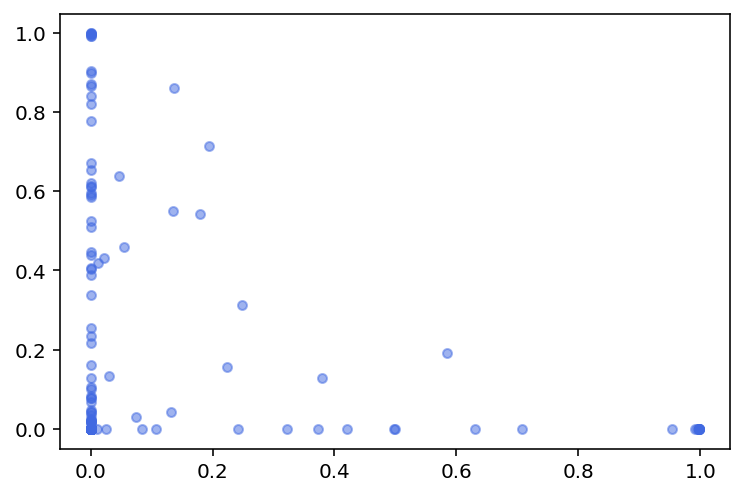

In [699]:
display_cluster(doc_topic)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


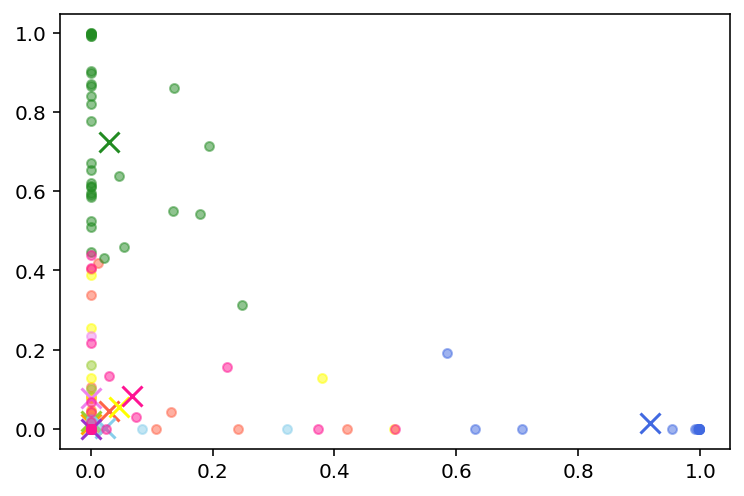

In [628]:
from sklearn.cluster import KMeans

num_clusters = 10 # my original number of topics 
km = KMeans(n_clusters=num_clusters)
km.fit(doc_topic)
display_cluster(doc_topic, km, num_clusters)


In [629]:
km.inertia_

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


11.965621394259987

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


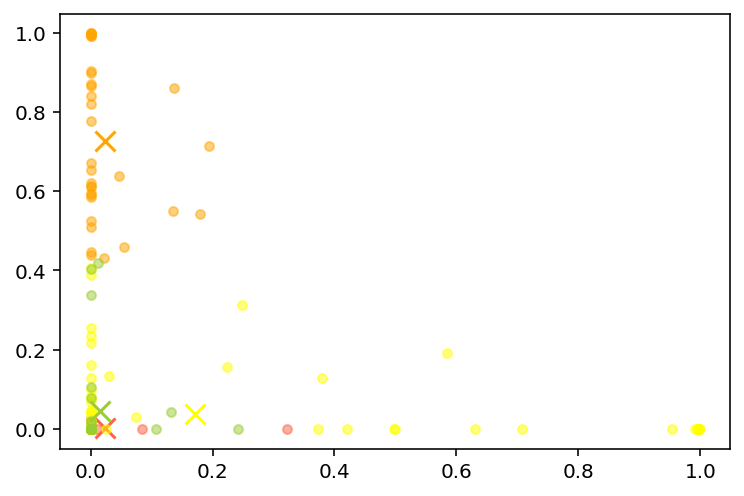

In [630]:
num_clusters = 4 # a randomly chosen smaller number of topics based on the image above
km = KMeans(n_clusters=num_clusters)
km.fit(doc_topic)
display_cluster(doc_topic, km, num_clusters)

In [631]:
km.inertia_

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


56.32207618460208

Plotting Inertia
Plotting various inertias to see the idea number of clusters and hence topics for my data.


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


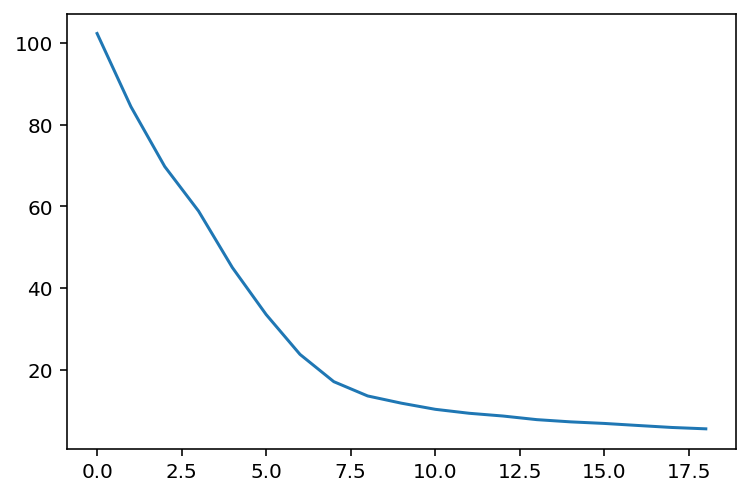

In [632]:
import matplotlib.pyplot as plt

inertias = []
for i in range(1, 20):
    km = KMeans(n_clusters=i)
    km.fit(doc_topic)
    inertia = km.inertia_
    inertias.append(inertia)

plt.plot(inertias)
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


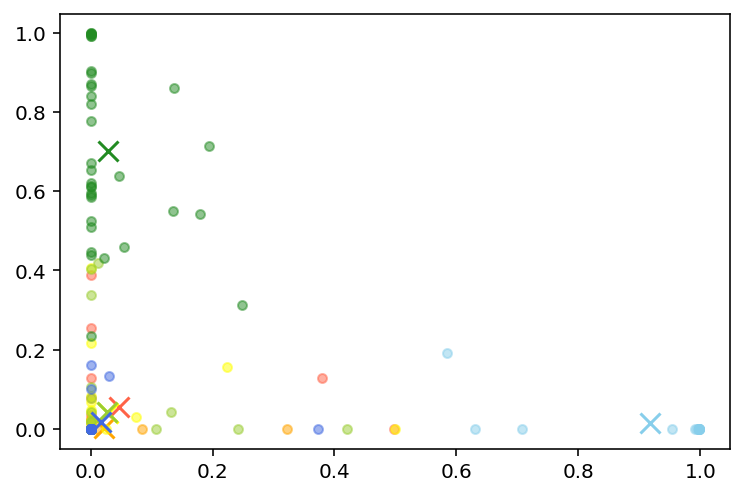

In [633]:
num_clusters = 7
km = KMeans(n_clusters=num_clusters)
km.fit(doc_topic)
display_cluster(doc_topic, km, num_clusters)

In [634]:
km.inertia_

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


23.833453473286312

Dimensionality Reduction & Visualization
Now! The grande finale! Visualization!

My goal in these visualizations is to see how similar or different the different type of documents (genres being Hinduism, Buddhism, Taosism, and Quantum Mechanics). Right now, the doc_topic matrix has a vector for each document of how much it falls into each topic. I am going to use PCA and t-SNE to reduce the doc_topic matrix's dimensions from 10 topics to 2-D space for plotting, then plot the space between all the documents. The colorization of types will then demonstrate how similar the genres are based on their topic vectors!



In [637]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(doc_topic)
pcafeatures = pca.transform(doc_topic)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [638]:
df_nosp["seid"]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0        S01E01
557      S01E02
837      S01E03
1078     S01E04
1308     S02E01
          ...  
52606    S09E17
52907    S09E18
53205    S09E19
53569    S09E20
53885    S09E23
Name: seid, Length: 173, dtype: object

In [639]:
target = df_nosp["seid"]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [641]:
target_names = list(target.unique())

print(doc_topic.shape)
print(pcafeatures.shape)

(173, 10)
(173, 2)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [642]:
print(len(pcafeatures))
print(len(target))

173
173


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [647]:
def plot_PCA(data, target, target_names):
    colors = cycle(['plum','dodgerblue', 'palegreen','red'])
    plt.figure(figsize=(10,10))
    for c, label in zip(colors, target_names):
        plt.scatter(data[target == label, 0], data[target == label, 1],
                   c=c, label=label, alpha=0.4, s=10)
    plt.legend()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


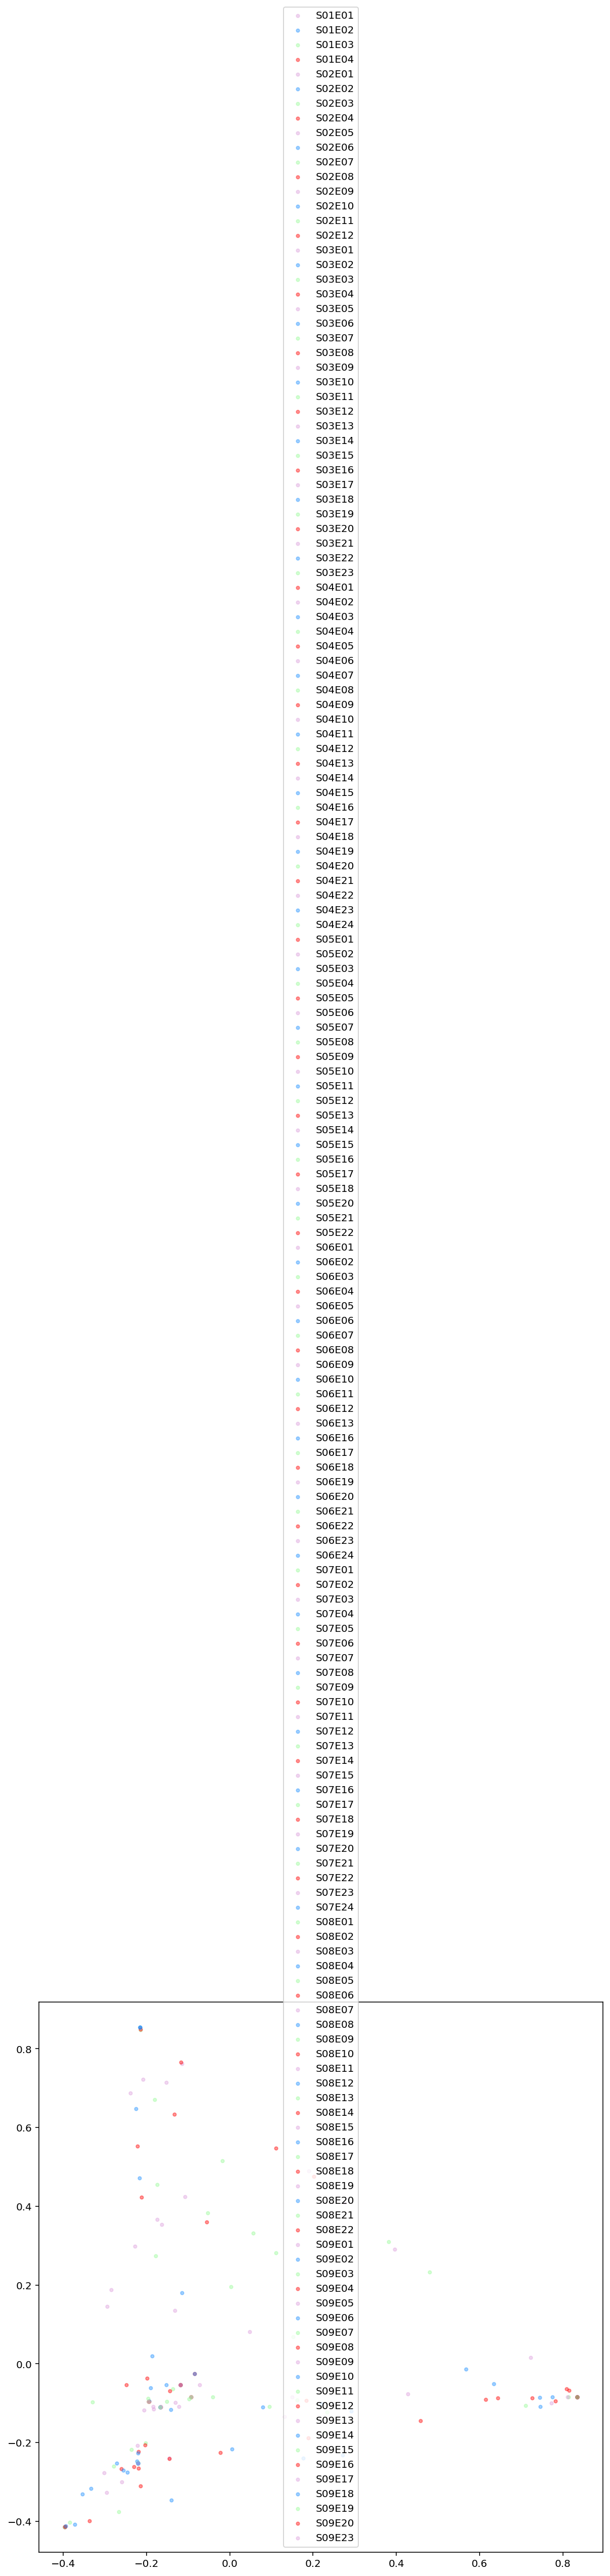

In [648]:
plot_PCA(pcafeatures, target=target, target_names=target_names)

## t-SNE 

In [651]:
tsne_model = TSNE(n_components=2, random_state=42)
tsne_data = tsne_model.fit_transform(doc_topic)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [652]:
def plot_tsne(data, target, target_names):
    colors = cycle(['plum','dodgerblue', 'palegreen','red'])
    for c, label in zip(colors, target_names):
        plt.scatter(low_data[target == label, 0], low_data[target == label, 1], c=c, label=label, s=0.4, alpha=0.5)
    plt.legend(fontsize=6, loc='upper left', frameon=True, facecolor='#FFFFFF', edgecolor='#333333')
    plt.xlim(-100,100);



/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [655]:
plot_tsne(tsne_data, target, target_names)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'low_data' is not defined

In [618]:
all_topic_words = []
for topic_id in range(lda_model.num_topics):
    topk = lda_model.show_topic(topic_id, 30)
    topk_words = [ w for w, _ in topk ]
    all_topic_words.append(topk_words)
    
    print('{}: {}'.format(topic_id, ' '.join(topk_words)))

0: key apartment show work open break listen pick glass keep year face love day buy play turn eat night whole life home mind help new meet hold bad point dog
1: work night listen eat love next second bad game person wear day test turn lot coffee open minute hit meet mind run keep number course live wrong whole read face
2: work money car book day problem listen buy eat table away pay fine thousand coffee minute love dollar point turn first keep show new check watch excuse long wear baby
3: bald hair tape coincidence listen chinese night toe house clean bad steal second hat team work english speak love side show remember watch keep day mind pick turn minute last
4: work day bad meet turn listen apartment love car run coffee movie hell new card pick night long whole away check year hold lot minute second keep enter sound eat
5: car day year minute new meet listen work lot love last first apartment dollar check help hold show drive run long away bad wear life care turn another eat keep
6:

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [619]:
all_topic_words

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['key',
  'apartment',
  'show',
  'work',
  'open',
  'break',
  'listen',
  'pick',
  'glass',
  'keep',
  'year',
  'face',
  'love',
  'day',
  'buy',
  'play',
  'turn',
  'eat',
  'night',
  'whole',
  'life',
  'home',
  'mind',
  'help',
  'new',
  'meet',
  'hold',
  'bad',
  'point',
  'dog'],
 ['work',
  'night',
  'listen',
  'eat',
  'love',
  'next',
  'second',
  'bad',
  'game',
  'person',
  'wear',
  'day',
  'test',
  'turn',
  'lot',
  'coffee',
  'open',
  'minute',
  'hit',
  'meet',
  'mind',
  'run',
  'keep',
  'number',
  'course',
  'live',
  'wrong',
  'whole',
  'read',
  'face'],
 ['work',
  'money',
  'car',
  'book',
  'day',
  'problem',
  'listen',
  'buy',
  'eat',
  'table',
  'away',
  'pay',
  'fine',
  'thousand',
  'coffee',
  'minute',
  'love',
  'dollar',
  'point',
  'turn',
  'first',
  'keep',
  'show',
  'new',
  'check',
  'watch',
  'excuse',
  'long',
  'wear',
  'baby'],
 ['bald',
  'hair',
  'tape',
  'coincidence',
  'listen',
  'ch

In [ ]:
doc_topic

In [ ]:
doc_topic.argmax(axis=1)

In [ ]:
df2['topic'] = doc_topic.argmax(axis=1)

In [ ]:
df2

## Doc: Season level

## Doc: Episode, character level

In [ ]:
epchar = df.copy()

In [ ]:
epchar = epchar.drop(['episodeno','seid','season','episodetext'],axis=1)

In [ ]:
epchar.info

**Total line counts per character (pre-clean) across all seasons**

In [ ]:
#drop_list = counter[counter['speaker'] == 'SEP'].index
#counter = counter.drop(drop_list)
epchar = epchar.groupby(['character'], as_index = False).count()
epchar = epchar.sort_values('text', ascending= False)
epchar.columns = ['character','lines count']
epchar = epchar.reset_index(drop = True)
epchar.iloc[:20]

In [ ]:
epchar2 = df.copy()

In [ ]:
epchar2 = epchar2.drop(['episodeno','seid','episodetext'],axis=1)

**Total line counts by character per season**

In [ ]:
#drop_list = counter[counter['speaker'] == 'SEP'].index
#counter = counter.drop(drop_list)
epchar2 = epchar2.groupby(['character','season'], as_index = False).count()
epchar2 = epchar2.sort_values('text', ascending= False)
epchar2.columns = ['character','season','lines_count']
epchar2 = epchar2.reset_index(drop = True)
epchar2.iloc[:20]

**Total line counts by char per season (main chars only)**

In [ ]:
nmlist = ['JERRY','GEORGE','KRAMER','ELAINE'] 
  
# selecting rows based on condition 
epchar3 = epchar2[epchar2['character'].isin(nmlist)]
epchar3

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df2.columns

**By char, what is the dist of line counts per season**

In [ ]:
plt.figure(figsize = (6, 6), facecolor = None)
#sns.set_palette("Paired")
sns.boxplot(x="character" ,y="lines_count", data=epchar3) # .iloc[:20])
plt.show()

In [ ]:
df_wide = epchar3.pivot("season","character","lines_count")
df_wide

In [ ]:
sns.lineplot(data=df_wide)

**Might need to get avg episodes per season to normalize these numbers**

**Idea: somehow get all text into one row of data per season/episode**